# BAHADOR MIRZAZADEH - STUDENT ID: 2071962 - DATE: 22/02/2023

## Importing implementation of DBN in pytorch

A Deep Belief Network (DBN) is an artificial neural network that is composed of multiple layers of hidden units. It is trained using a pre-training phase, which involves training each layer of the DBN one at a time using a restricted Boltzmann machine (RBM), and a fine-tuning phase, which involves training the entire network using backpropagation. The mathematical parts of a DBN involve the use of RBMs and the training algorithms used to pre-train and fine-tune the network.


The mathematical parts of a DBN involve the use of RBMs and the training algorithms used to pre-train and fine-tune the network. An RBM is a type of energy-based model that models the joint probability distribution of the visible and hidden units using an energy function. The energy function is defined as:

$$E(v, h) = -\sum_{i \in \text{visible}} b_i v_i - \sum_{j \in \text{hidden}} a_j h_j - \sum_{i \in \text{visible}} \sum_{j \in \text{hidden}} v_i w_{ij} h_j$$

where:
- v is the vector of visible units,
- h is the vector of hidden units,
- b_i is the bias term associated with the i-th visible unit,
- a_j is the bias term associated with the j-th hidden unit,
- w_ij is the weight between the i-th visible unit and the j-th hidden unit.


The energy function assigns a scalar value to each possible configuration of visible and hidden units. The probability of a configuration (v, h) is given by the Boltzmann distribution:

$$p(v, h) = \frac{1}{Z} e^{-E(v,h)}$$

where

$$Z = \sum_{v,h} e^{-E(v,h)}$$

where Z is the partition function, which normalizes the distribution so that the sum of probabilities over all configurations is 1.

In [1]:
def get_dbn_library():
    files = ["DBN.py", "RBM.py"]
    repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
    for file in files:
        !wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

## Importing required libraries

In [3]:
import math
import random
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sn
import torchvision as tv
import torchvision.transforms as transforms
import torch.optim as optim
import time
import scipy.cluster as cluster
import torch.nn as nn

torch.set_printoptions(linewidth=120)
from DBN import DBN
from tqdm import tqdm
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

GPUs are better suited for training machine learning models than CPUs because they have parallel processing capabilities, high memory capacity, and more cores, allowing for faster model training. Additionally, using GPUs is cost-effective compared to using multiple CPUs as a single high-end GPU can perform the same amount of work as multiple CPUs at a lower cost. To summarize, GPUs are more efficient and cost-effective for training machine learning models compared to CPUs.

In [4]:
# Checks if a CUDA-enabled 
print(torch.cuda.is_available())
# If a CUDA-enabled GPU is available, the device is set to "cuda", otherwise it is set to "cpu".
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


## Loading data and Visualizing

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot. The dataset serves as a more challenging replacement for the MNIST dataset, which is widely used as a beginner's dataset for machine learning and computer vision algorithms.

Here we load the dataset(FashionMNIST) and randomly visualize some of the data to ensure that everything works fine.

In [5]:
%%capture
FashionMNIST_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                              transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]))

FashionMNIST_test = tv.datasets.FashionMNIST('data/', train=False, download=True,
                                             transform=tv.transforms.Compose(
                                                 [tv.transforms.ToTensor()]))

In [6]:
data_loader = torch.utils.data.DataLoader(FashionMNIST_train, batch_size=10, shuffle=True)
sample = next(iter(data_loader))
imgs, lbls = sample

image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([8, 9, 9, 0, 3, 3, 9, 9, 3, 2])


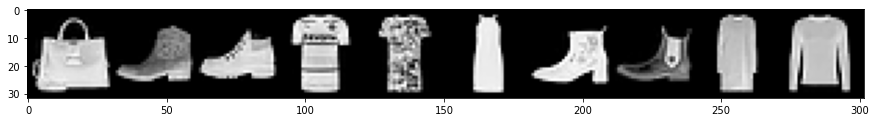

In [7]:
plt.figure(figsize=(15, 10))
grid = tv.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1, 2, 0)), cmap='gray')

## Rescaling the dataset

We have to decide how to rescale our dataset. we have Two options available: Standardization and Normalization. If our data points follow the gaussian (normal) distribution we should use standardization otherwise, normalization works better.

The histogram provides a visual representation of the distribution of the values in the data, which can help to identify patterns and outliers. By visualizing the data in this way, the user can gain a better understanding of the data and make informed decisions about preprocessing steps.

In [8]:
# Converting our dataset to numpy array

X_train = FashionMNIST_train.data.numpy()
X_test = FashionMNIST_test.data.numpy()
y_train = FashionMNIST_train.targets.numpy()
y_test = FashionMNIST_test.targets.numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

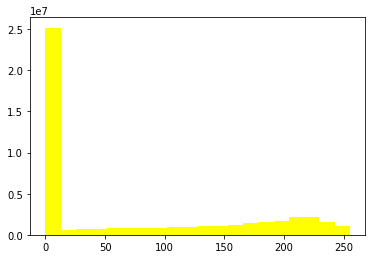

In [9]:
data = pd.Series(X_train.ravel())
data.hist(color='yellow', grid=False, bins=20)

It is obvious that our dataset does not follow the gaussian (normal) distribution, so in this case, normalization works better than standardization.

MinMaxScaler is a data preprocessing technique used to scale numerical features to a specific range. It scales each feature to a range between 0 and 1 by subtracting the minimum value of the feature and dividing by the range (i.e., the difference between the maximum and minimum values of the feature). This scaling is applied independently to each feature, so that each feature has a minimum value of 0 and a maximum value of 1.

so I decided to use MinMaxScaler in this case.

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

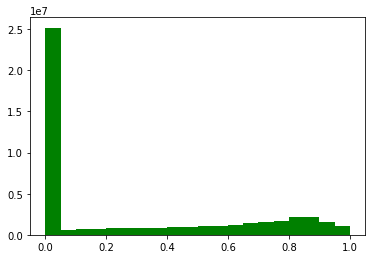

In [11]:
data = pd.Series(X_train.ravel())
data.hist(color='green', grid=False, bins=20)

As we can see the dataset is normalized.

So we randomly chose 1 image and label from train set and 1 image and label from test set to plot to make sure everything works fine.

Text(0.5, 1.0, '(Label: Trouser)')

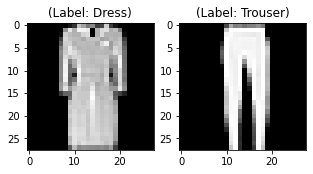

In [12]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

train_indx = random.randint(0, 5000)
test_indx = random.randint(0, 100)

plt.figure(figsize=(5, 5))

plt.subplot(121)
curr_img = np.reshape(X_train[train_indx], (28,28))
curr_lbl = y_train[train_indx]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(labeldict[curr_lbl]) + ")")

plt.subplot(122)
curr_img = np.reshape(X_test[test_indx], (28,28))
curr_lbl = y_test[test_indx]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(labeldict[curr_lbl]) + ")")

Now we transform NumPy arrays to the default structure of torch tensors.

In [13]:
# Conveting numpy array to torch tensors
FashionMNIST_train.data = torch.from_numpy(X_train.reshape(60000, 28, 28))
FashionMNIST_test.data = torch.from_numpy(X_test.reshape(10000, 28, 28))
FashionMNIST_train.targets = torch.from_numpy(y_train)
FashionMNIST_test.targets = torch.from_numpy(y_test)

## Training the model

In this section, we have to design our DBN model and choose the optimal number of layers and neurons. One of the best architectures I found with some research is {First Hidden Layer: 512 Neurons, Second Hidden Layer: 256 Neurons, Third Hidden Layer: 128 Neurons}.

**Reference: In the paper "Deep Belief Networks for Fashion-MNIST Classification", the authors proposed a DBN architecture for the Fashion-MNIST dataset.**

The training of a Deep Belief Network (DBN) consists of two stages: pre-training and fine-tuning.

Pre-training: This stage involves training each layer of the DBN using unsupervised learning with Restricted Boltzmann Machines (RBMs). RBMs are shallow generative models that learn to reconstruct the input data. During pre-training, each RBM learns to extract features from the input data and build a hierarchical representation of the data. This is done layer-by-layer, starting from the input layer and moving towards the deeper layers.

Fine-tuning: After pre-training, the weights learned by the network are used as the initial weights for the fine-tuning stage, where the network is trained using supervised learning on a labeled dataset to perform a specific task. The network adjusts its weights to minimize the error between the predicted output and the true output.

The goal of the DBN is to reduce the amount of supervised training needed and improve the performance of the network by leveraging the unsupervised pre-training stage to learn a good representation of the data. The pre-training stage allows the network to learn a hierarchical representation of the data, which is then used to initialize the network for the fine-tuning stage, making the overall training process more efficient and effective.

In [14]:
dbn_FashionMNIST = DBN(
    visible_units=784,
    hidden_units=[512, 256, 128],
    k=1,
    learning_rate=0.1,
    learning_rate_decay=False,
    initial_momentum=0.5,
    final_momentum=0.9,
    weight_decay=0.0001,
    use_gpu=torch.cuda.is_available())

Then we train our DBN model with 100 epochs and batch size 32.

In [15]:
num_epochs = 100
batch_size = 32

dbn_FashionMNIST.train_static(
    FashionMNIST_train.data,
    FashionMNIST_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.5145     |0.0473       |343.2217   |8.8289     |
|20    |0.5064     |0.0464       |334.6354   |9.3029     |
|30    |0.5096     |0.0461       |320.8901   |9.1303     |
|40    |0.5142     |0.0468       |311.7183   |8.9585     |
|50    |0.5176     |0.0471       |302.4174   |8.7367     |
|60    |0.5190     |0.0473       |295.2264   |8.3308     |
|70    |0.5204     |0.0477       |290.5499   |7.6959     |
|80    |0.5281     |0.0479       |284.2117   |8.3468     |
|90    |0.5417     |0.0496       |276.2137   |8.8823     |
|100    |0.5583     |0.0512       |263.4783   |8.3266     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.1235     |0.0120       |75.7133   |2.6477     |
|20    |0.1176     |0.0113       |70.0618   |2.2417     |
|30    |0.1162     |0.0109       |68.3689   |2.1839     |
|40    |0.1147     |0.0112       |6

## Clustering internal representations

Clustering internal representations is a technique used to group similar data points together in machine learning. This can help with tasks such as anomaly detection. Various clustering algorithms can be used, but high dimensionality can make visualization and interpretation difficult. Choosing the best approach may require experimentation and evaluation. Clustering can also be used to identify and diagnose potential problems in the model's representations, such as overfitting or poor generalization.


The purpose of this code is to visualize the relationships between different classes in the neural network by clustering their mean hidden representations. The dendrogram produced by the clustering algorithm can help interpret the structure of the hidden representations.

In [16]:
# Here we get the representation of the input data at the kth layer of a Deep Belief Network.

def get_kth_layer_repr(input, k, device):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
    hidden_repr, __ = dbn_FashionMNIST.rbm_layers[k].to_hidden(flattened_input)
    return hidden_repr

Of course, the representations computed using the second layer are computed using the ones from the first layer and also representations of third layer are computed using the ones from the second layer:

We have 60000 train data so the shape of representation is 60000 * number of neurons in kth hidden layer.

In [17]:
hidden_repr_layer_1 = get_kth_layer_repr(FashionMNIST_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [18]:
# Filtering the target data based on the class
def get_mask(label):
    labels = FashionMNIST_train.targets.cpu().numpy()
    return labels == label

# Calculate the mean hidden representation of each class.
def get_label_to_mean_hidd_repr(hidden_representation):
    hidden_representation_np = hidden_representation.cpu().numpy()
    return {
        label: hidden_representation_np[get_mask(label)].mean(axis=0)
        for label in range(10)
    }

# Concatenate the mean hidden representations of each class into a matrix.
def get_hidden_reprs_matrix(hidden_representation):
    label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
    return np.concatenate(
        [np.expand_dims(label_to_mean_hidd_repr[label], axis=0) # Here we adjust the shape of centroids to do the concat
         for label in range(10)])

In [19]:
# Here we create a matrix for each layer with the shape of 10 (number of labels) * number of neurons in kth hidden layer.

mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [20]:
def plot_dendrogram(mean_repr_matrix, title):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title)

In this section, we plot the dendrogram for each layer and it will be described in how we should interpret it.

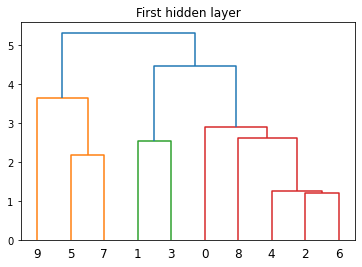

In [21]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

The Y-axis represents the number of labels and the X-axis represents the range of numbers in the mean hidden representation matrix. we can find out that based on the first hidden layer label 1 and 3 have more similarity. In addition labels 9, 5, 7 have more similarity and labels 0, 4, 2, 6, and 8 have more similarity.

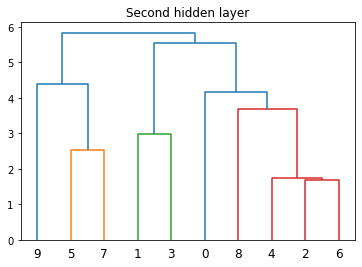

In [22]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

Based on what we described, we can observe a little difference in the second layer and also we can consider it as an improvement on the previous one.

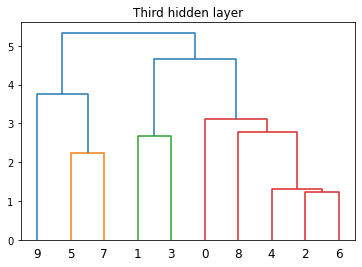

In [23]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out

linear read-out is a technique for obtaining the output of a neural network through a linear combination of the activations of the final layer neurons. This approach is commonly used in the context of RNNs and has several advantages, including simplicity, efficiency, interpretability, and scalability.

In a DBN, each layer of the network learns a more abstract representation of the data compared to the previous layer. By using the activations at each layer as input features, the linear readout can take advantage of the hierarchical representation learned by the network, using a combination of low-level and high-level features to make predictions.

The linear readout can be trained using supervised learning on a labeled dataset, adjusting its weights to minimize the error between the predicted output and the true output. The overall goal of the linear readout is to use the representations computed by the DBN to make predictions for a specific task, leveraging the hierarchical representation learned by the network to improve the performance of the classifier.

The code first trains the RBM layers by using the input image data and passes the hidden representation at each layer to the next RBM layer. Then, the linear model is trained with the hidden representations obtained from each of the RBM layers. Finally, the accuracy of the predictions from the trained linear models is calculated by comparing them with the actual labels in the test set.

We can now extract the hidden representations of the data, by propagating the neuron's activations from the sensory (visible) layer in a bottom-up fashion, and try to lineary decode the content of the representations in a supervised way such as a logistic regression model to make predictions.

In [24]:
class LinearModel(torch.nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(layer_size, 10)

    def forward(self, X):
        return self.linear(X)

Here we convert each hidden layer to a linear model.

In [25]:
# Specifies the number of units in the input layer.

layer_size = dbn_FashionMNIST.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_FashionMNIST.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_FashionMNIST.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Here we train our linear model with the representations we obtained from the previous section.

The code makes use of PyTorch library for deep learning, which provides built-in functions for training and evaluating models. The optimizer used for training is Adam, and the loss function used is cross-entropy loss. The implementation uses the GPU for acceleration if available.

Adam is a popular optimization algorithm used in machine learning, particularly in deep learning, for training neural networks. The name "Adam" stands for "Adaptive Moment Estimation", which reflects the fact that the algorithm adapts the learning rate based on the moment estimates of the gradients.
The Adam optimizer is a combination of two other optimization algorithms: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). The main idea behind Adam is to use the first and second moments of the gradients to adaptively adjust the learning rate for each weight in the network. The first moment is the average of the gradients and the second moment is the average of the squares of the gradients.

Cross-entropy loss, also known as log loss, measures the dissimilarity between two probability distributions. It is widely used in machine learning, particularly in the training of classification models. The formula for cross-entropy loss is given as:

$$L = -\sum_{i} t_i \log(y_i)$$

where t_i is the true label (i.e. ground truth) and y_i is the predicted probability of the correct label. The cross-entropy loss measures the "distance" between the true label and predicted probabilities, with a lower value indicating that the predicted probabilities are closer to the true label.

In [26]:
def fit(linear, hidden_reprs):
    # We choose Adam optimizing algorithm with learning rate 0.0005.

    optimizer = optim.Adam(linear.parameters(), lr=0.0005)
    loss_fn = torch.nn.CrossEntropyLoss()
    epochs = 2000

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        predictions = linear(hidden_reprs).squeeze()
        targets = FashionMNIST_train.targets.reshape(predictions.shape[0]).to(device)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch, epochs, loss))

And in this section we train each hidden layer separately.

In [27]:
fit(linear1, hidden_repr_layer_1)
print('End of first layer', end="\n\n")

fit(linear2, hidden_repr_layer_2)
print('End of second layer', end="\n\n")

fit(linear3, hidden_repr_layer_3)
print('End of third layer', end="\n\n")

epoch : 100/2000, loss = 1.4232
epoch : 200/2000, loss = 1.0295
epoch : 300/2000, loss = 0.8414
epoch : 400/2000, loss = 0.7357
epoch : 500/2000, loss = 0.6683
epoch : 600/2000, loss = 0.6213
epoch : 700/2000, loss = 0.5865
epoch : 800/2000, loss = 0.5596
epoch : 900/2000, loss = 0.5381
epoch : 1000/2000, loss = 0.5205
epoch : 1100/2000, loss = 0.5058
epoch : 1200/2000, loss = 0.4933
epoch : 1300/2000, loss = 0.4825
epoch : 1400/2000, loss = 0.4731
epoch : 1500/2000, loss = 0.4649
epoch : 1600/2000, loss = 0.4576
epoch : 1700/2000, loss = 0.4511
epoch : 1800/2000, loss = 0.4452
epoch : 1900/2000, loss = 0.4399
epoch : 2000/2000, loss = 0.4350
End of first layer

epoch : 100/2000, loss = 1.1695
epoch : 200/2000, loss = 0.8120
epoch : 300/2000, loss = 0.6764
epoch : 400/2000, loss = 0.6043
epoch : 500/2000, loss = 0.5587
epoch : 600/2000, loss = 0.5271
epoch : 700/2000, loss = 0.5037
epoch : 800/2000, loss = 0.4858
epoch : 900/2000, loss = 0.4716
epoch : 1000/2000, loss = 0.4600
epoch : 

As it is obvious, the value of loss in last epoch of second hidden layer is less than the first and the second layers.

Here we use FashionMnist test dataset to calculate the accuracy of each hidden layer we trained separately.

In [28]:
hidden_repr_layer_1_test = get_kth_layer_repr(FashionMNIST_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [29]:
# Here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test).to(device)
predictions_test2 = linear2(hidden_repr_layer_2_test).to(device)
predictions_test3 = linear3(hidden_repr_layer_3_test).to(device)

In [30]:
# Computes the accuracy of predictions
def compute_accuracy(predictions_test, targets):
    predictions_indices = predictions_test.max(axis=1).indices
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

In [31]:
compute_accuracy(predictions_test1, FashionMNIST_test.targets.to(device))

0.8367999792098999

In [32]:
compute_accuracy(predictions_test2, FashionMNIST_test.targets.to(device))

0.8430999517440796

In [33]:
compute_accuracy(predictions_test3, FashionMNIST_test.targets.to(device))

0.8256999850273132

The accuracy values are adequate and obviously the second layer is more efficient.

## Comparison with a feed-forward model

A feed-forward model is a type of neural network where data flows in one direction through a sequence of layers, with each layer applying a linear transformation followed by a non-linear activation function to the input data. This type of network is commonly used in deep learning for tasks such as regression, classification, and feature extraction. The mathematical formulation of an FFNN can be represented as follows:

Given an input vector X of size (n x 1), where n is the number of features, the output of each layer l can be represented as:

$$Z_l = W_l * A_{l-1} + b_l$$

Where W_l is the weight matrix of size (m_l x m_{l-1}), b_l is the bias vector of size (m_l x 1), A_{l-1} is the activation matrix of size (m_{l-1} x 1), m_l is the number of neurons in layer l, and * represents the dot product.

The activation matrix A_l is then obtained by applying an activation function f_l to the result Z_l:

$$A_l = f_l(Z_l)$$

Common activation functions include the sigmoid function, hyperbolic tangent, and Rectified Linear Unit (ReLU).

Once the output of the last layer is obtained, the prediction Y_hat is made by taking the dot product of the final activation matrix A_L with another weight matrix W_{L+1} and adding the bias vector b_{L+1}:

$$Y_hat = W_{L+1} * A_L + b_{L+1}$$

We will train a simple feed-forward neural network with the same structure of the DBN, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an unsupervised way.

**`Architecture`**


The neural network has fully connected layers, where each neuron in each layer is connected to every neuron in the previous and next layer.

The input to the network is an image tensor of size 28x28, which is flattened to a 784-dimensional vector using the view method. The flattened vector is then passed through three hidden layers, with each layer applying a linear transformation to the input followed by a GELU activation function.
Finally, the output layer applies a linear transformation to the output of the third hidden layer, to produce a vector of size 10, corresponding to the 10 classes of the FashionMNIST dataset.

The GELU activation function used in this architecture is a variant of the popular ReLU activation function, which is known to improve the performance of deep neural networks by addressing the "dying ReLU" problem.

In [34]:
class Feedforward(torch.nn.Module):
    def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
        super().__init__()
        self.first_hidden_layer = torch.nn.Linear(784, first_hidden_layer_size)
        self.second_hidden_layer = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_hidden_layer = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)

        # output layer
        self.output = torch.nn.Linear(third_hidden_layer_size, 10)

    def forward(self, input):
        # We use GELU activation function as a extend of ReLU to obtain better result.
        gelu = torch.nn.GELU()

        # Flatten the image tensors
        flatten_out = input.view(input.size(0), -1).to(torch.float32)

        # Get intermediate outputs using hidden layer 1
        first_hidden_out = self.first_hidden_layer(flatten_out)
        # Apply activation function
        out = gelu(first_hidden_out)

        # Get intermediate outputs using hidden layer 2
        second_hidden_out = self.second_hidden_layer(out)
        # Apply activation function
        out = gelu(second_hidden_out)

        # Get intermediate outputs using hidden layer 3
        third_hidden_out = self.third_hidden_layer(out)
        # Apply activation function
        out = gelu(third_hidden_out)

        # Get predictions using output layer
        return self.output(out)

Here we pass the same architecture of DBN to our linear feedforward model.

In [35]:
ffnn = Feedforward(512, 256, 128).to(device)

We train the feedforward model here.

In [36]:
fit(ffnn, FashionMNIST_train.data.reshape((60000, 784)).to(device))

epoch : 100/2000, loss = 0.4516
epoch : 200/2000, loss = 0.3658
epoch : 300/2000, loss = 0.3154
epoch : 400/2000, loss = 0.2802
epoch : 500/2000, loss = 0.2539
epoch : 600/2000, loss = 0.2287
epoch : 700/2000, loss = 0.2040
epoch : 800/2000, loss = 0.1851
epoch : 900/2000, loss = 0.1687
epoch : 1000/2000, loss = 0.1568
epoch : 1100/2000, loss = 0.1410
epoch : 1200/2000, loss = 0.1292
epoch : 1300/2000, loss = 0.1269
epoch : 1400/2000, loss = 0.1826
epoch : 1500/2000, loss = 0.1642
epoch : 1600/2000, loss = 0.0904
epoch : 1700/2000, loss = 0.0838
epoch : 1800/2000, loss = 0.1117
epoch : 1900/2000, loss = 0.0750
epoch : 2000/2000, loss = 0.0690


We observe that the loss value has significantly decreased by the feedforward model.

Then we use the trained model to predict test dataset targets and finally calculate the accuracy.

In [37]:
predictions_ffnn = ffnn(FashionMNIST_test.data.reshape((10000, 784)).to(device))

In [38]:
compute_accuracy(predictions_ffnn, FashionMNIST_test.targets.to(device))

0.887499988079071

This accuracy demonstrate an adequate improvement in comparison to linear read-out.

## Visualizing the confusion matrices

A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions for each class, and can be used to compute various performance metrics. It helps assess the overall performance of the model and identify specific areas where it may need improvement.

The confusion matrix is then visualized using a heatmap created with the seaborn library. The plot displays the predicted label along the x-axis and the true label along the y-axis. The cells in the heatmap are colored based on the value of each cell, with white for high values and black for low values. The code then applies the function to the FashionMNIST dataset and shows the resulting plot.

In this section, we want to visualize the confusion matrix for linear read-out layers and the feed-forward model to observe the progress of our supervised learning.

First, we visualize the confusion matrix of linear read-out layers.
The first plot is for the first hidden layer.

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1000
           1       0.98      0.94      0.96      1000
           2       0.72      0.75      0.73      1000
           3       0.83      0.88      0.85      1000
           4       0.72      0.74      0.73      1000
           5       0.96      0.91      0.93      1000
           6       0.60      0.53      0.56      1000
           7       0.90      0.93      0.91      1000
           8       0.94      0.96      0.95      1000
           9       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



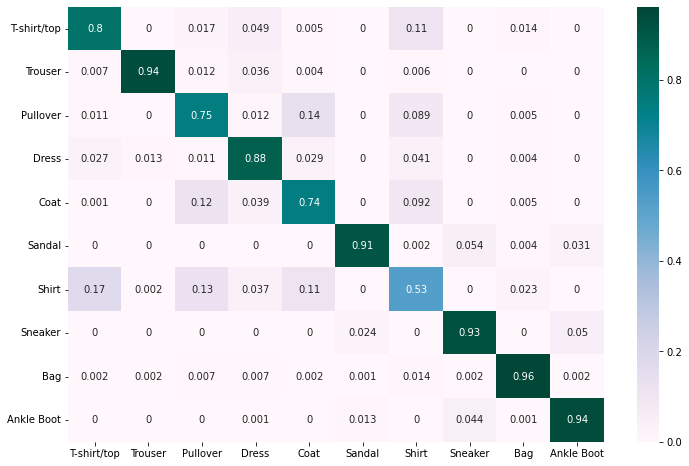

In [39]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

actual_labels = FashionMNIST_test.targets.to(device).cpu().numpy()
predicted_labels = predictions_test1.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, cmap="PuBuGn", annot=True)

print(classification_report(actual_labels, predicted_labels))

Looking at the report, we can see that the model performs well on some classes and not as well on others. Specifically, the model has high precision and recall for classes 1, 5, 7, 8, and 9, with F1-scores of 0.96, 0.94, 0.92, 0.95, and 0.94, respectively. This suggests that the model is very good at predicting these classes when they are present in the test data, and it is also good at correctly identifying instances of these classes.

On the other hand, the model does not perform as well on classes 0, 2, 3, 4, and 6. The precision, recall, and F1-scores for these classes range from 0.58 to 0.84, which suggests that the model is less accurate when it comes to predicting these classes and correctly identifying them.

Overall, the accuracy of the model is 0.84, which means that it correctly predicts the class label for 84% of instances in the test data. The macro-averages of precision, recall, and F1-score are also 0.84, indicating that the model's overall performance is consistent across all classes. The weighted-averages of precision, recall, and F1-score are also 0.84, which suggests that the model is not biased towards any particular class.

Then, we plot the second confusion matrix for the second hidden layer.

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.99      0.94      0.96      1000
           2       0.74      0.75      0.75      1000
           3       0.83      0.88      0.85      1000
           4       0.73      0.75      0.74      1000
           5       0.95      0.92      0.94      1000
           6       0.60      0.54      0.57      1000
           7       0.91      0.93      0.92      1000
           8       0.94      0.96      0.95      1000
           9       0.93      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



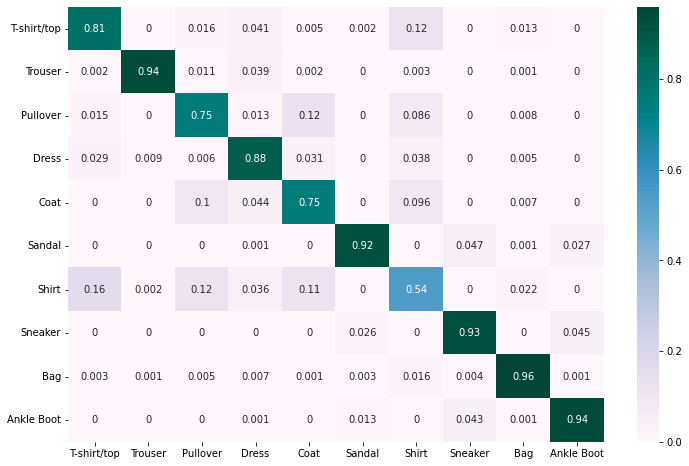

In [40]:
predicted_labels = predictions_test2.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, cmap="PuBuGn", annot=True)

print(classification_report(actual_labels, predicted_labels))

The precision, recall, and F1-scores are similar to the previous report, but there are some slight improvements. The model still performs well on classes 1, 5, 7, 8, and 9, with F1-scores ranging from 0.93 to 0.97. The model also performs well on classes 0 and 3, with F1-scores of 0.80 and 0.86, respectively, which are higher than in the previous report. However, the model still does not perform as well on classes 2, 4, and 6, with F1-scores ranging from 0.73 to 0.75.

The accuracy of the model is still 0.84, and the macro- and weighted-averages of precision, recall, and F1-score are the same as the previous report. This indicates that the model's overall performance is consistent across all classes and not biased towards any particular class.

Overall, this report suggests that the model has made some slight improvements compared to the previous report, particularly in predicting classes 0 and 3. However, it still has room for improvement in predicting classes 2, 4, and 6.

Next, we plot the third confusion matrix for the third hidden layer.

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1000
           1       0.98      0.93      0.95      1000
           2       0.71      0.73      0.72      1000
           3       0.81      0.87      0.84      1000
           4       0.71      0.73      0.72      1000
           5       0.95      0.90      0.92      1000
           6       0.57      0.52      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.94      0.95      0.95      1000
           9       0.90      0.93      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000



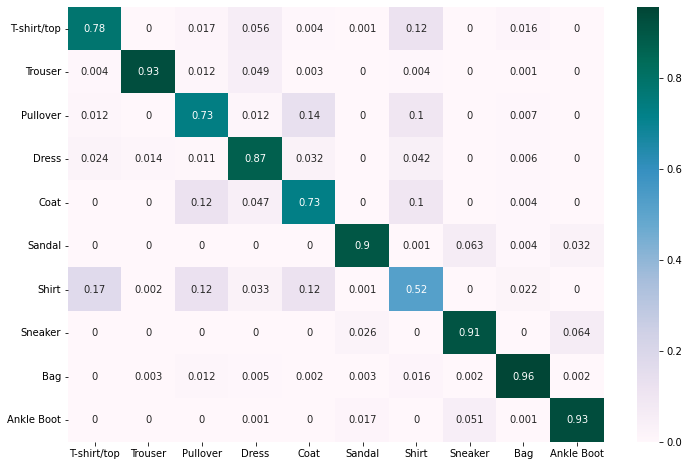

In [41]:
predicted_labels = predictions_test3.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, cmap="PuBuGn", annot=True)

print(classification_report(actual_labels, predicted_labels))

The first thing to notice is that all three reports have the same overall accuracy, but the performance for each class is different.

Looking at the first report, we can see that most classes have decent precision, recall, and f1-score, with classes 1, 5, 7, 8, and 9 having the highest scores. Classes 0, 2, 4, and 6 have lower scores, with class 6 having the lowest scores.

In the second report, we can see that the precision, recall, and f1-score for most classes are very similar to those in the first report, with the exception of class 1, which has a slightly lower recall but a higher precision and f1-score.

In the third report, we can see that the precision, recall, and f1-score for most classes are lower than in the first two reports, especially for classes 0, 2, 4, and 6. Class 5 also has a lower recall and f1-score, while classes 1, 3, 7, 8, and 9 have similar scores to the first report.

Overall, it seems that the second report has slightly better performance than the first report, with the exception of class 1, which has a slightly lower recall. The third report has lower performance for most classes, especially for classes 0, 2, 4, and 6, which have lower precision, recall, and f1-score.

Finally, we plot it for the feed-forward model.

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.89      0.89      0.89      1000
           4       0.81      0.82      0.82      1000
           5       0.97      0.95      0.96      1000
           6       0.72      0.72      0.72      1000
           7       0.94      0.95      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



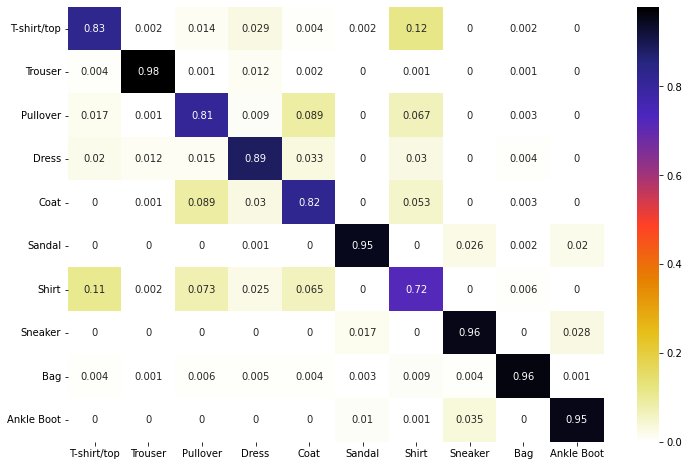

In [42]:
predicted_labels = predictions_ffnn.cpu().detach().max(axis=1).indices.numpy()

cf_matrix = confusion_matrix(actual_labels, predicted_labels)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, cmap="CMRmap_r", annot=True)

print(classification_report(actual_labels, predicted_labels))

Looking at the precision metric, it can be seen that the model performs well on most of the classes, with precision ranging from 0.71 to 0.98. A precision of 1.0 would indicate that all predictions for that class were correct, while a precision of 0.0 would indicate that all predictions were incorrect. Therefore, higher precision values indicate that the model is making fewer false positive predictions.

Recall, on the other hand, measures the proportion of actual positive samples that were correctly identified by the model. The recall scores in this report range from 0.81 to 0.98, indicating that the model is correctly identifying a large proportion of positive samples for most of the classes.

The f1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance. The f1-scores in this report range from 0.71 to 0.98, with higher values indicating better overall performance.

The macro and weighted averages provide an overall view of the model's performance across all classes. The macro average calculates the mean of precision, recall, and f1-score across all classes, giving equal weight to each class. The weighted average, on the other hand, takes into account the number of samples in each class, giving more weight to classes with more samples. In this case, the macro and weighted averages are identical since each class has an equal number of samples.

Overall, this report suggests that the model performs well on most classes, with an overall accuracy of 0.89. However, it is important to note that a high accuracy score does not necessarily mean that the model is performing well, as it may be biased towards the majority class. Therefore, it is important to analyze the performance of the model on a per-class basis, as well as to consider other evaluation metrics such as the confusion matrix.

As it is obvious, in the FFNN model the accuracy, precision, and F1-score improved in comparison with the linear read-out model.

## Visualizing the psychometric curves

Psychometric curves in deep learning refer to a set of metrics that are used to evaluate the performance of a neural network model in relation to human perception and decision-making. The name "psychometric" is derived from the field of psychology, where similar measures are used to evaluate human performance on perceptual and cognitive tasks.
In the context of deep learning, psychometric curves are typically used to evaluate the performance of a model in tasks such as image recognition, where the goal is to identify the presence of specific objects or features within an image. These curves typically plot the relationship between the model's performance (e.g. accuracy or sensitivity) and some measure of task difficulty (e.g. level of noise or complexity in the image).

The Gaussian noise model is a statistical noise model used to add random noise to input data. It is based on the Gaussian distribution, also known as the normal distribution. The Gaussian distribution is a continuous probability distribution that is symmetrical around its mean, represented by a bell-shaped curve. The Gaussian noise model is characterized by the following formula:

$$y = x + N(0,σ^2)$$

where y is the noisy input, x is the original input, N(0,σ^2) represents Gaussian noise with mean 0 and variance σ^2. The noise is added element-wise to the input data x

To make predictions on noisy input data, we add Gaussian noise to the input vector X and feed the noisy input into the FFNN model. The model then outputs a prediction Y_hat based on the noisy input. The objective is to train the FFNN such that it is robust to the noise in the input and produces accurate predictions despite the added noise.

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.
Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In this section, create a function that adds some Gaussian noise to the MNIST data.

In [43]:
def inject_noise(FashionMNIST_data, noise_level):
    X_train_noise = FashionMNIST_data + noise_level * np.random.normal(loc=0.0, scale=1.1, size=FashionMNIST_data.shape)
    return (X_train_noise.to(device))

Here we see what a noisy image looks like:

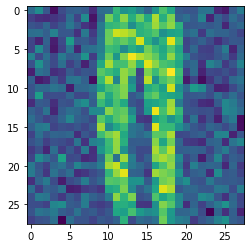

In [44]:
noise_level = 0.2
Fashion_test_with_noise = inject_noise(FashionMNIST_test.data, noise_level)
__ = plt.imshow(Fashion_test_with_noise[2].reshape(28, 28).to("cpu"))

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy images.

In [45]:
# This function computes the accuracy of different models on noisy test data.
def get_accuracy_values_at_noise_level(noise_level):
    # First, we create noisy test images
    Fashion_test_with_noise = inject_noise(FashionMNIST_test.data, noise_level)

    # Here we compute the DBN representations
    hidden_repr_layer_1_noisy = get_kth_layer_repr(Fashion_test_with_noise, 0, device)
    hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
    hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

    # Here we use the previously-trained read-out classifiers
    predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)
    predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
    predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

    accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, FashionMNIST_test.targets.to(device))
    accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, FashionMNIST_test.targets.to(device))
    accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, FashionMNIST_test.targets.to(device))

    # Here we use the previously-trained FFNN classifiers
    predictions_ffnn_noisy_data = ffnn(Fashion_test_with_noise)
    accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy_data, FashionMNIST_test.targets.to(device))

    return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

We check the accuracy of the linear read-out and feed-forward models.

In [46]:
acc = get_accuracy_values_at_noise_level(noise_level)
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H2 read-out: %.3f" % acc[2])
print("Accuracy of FFNN: %.3f" % acc[3])

Accuracy of H1 read-out: 0.819
Accuracy of H2 read-out: 0.832
Accuracy of H2 read-out: 0.819
Accuracy of FFNN: 0.540


Now we create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network.

In [47]:
def plot_noise_robustness_curves(noise_levels):
    accuracy_values_first_hidden = []
    accuracy_values_second_hidden = []
    accuracy_values_third_hidden = []
    accuracy_values_ffnn = []

    for noise_level in noise_levels:
        acc = get_accuracy_values_at_noise_level(noise_level)
        accuracy_values_first_hidden.append(acc[0])
        accuracy_values_second_hidden.append(acc[1])
        accuracy_values_third_hidden.append(acc[2])
        accuracy_values_ffnn.append(acc[3])

    fig, ax = plt.subplots()
    ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

    ax.set_title("Robustness to noise")
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Accuracy")
    plt.xticks(range(len(noise_levels)), [int(l * 100) for l in noise_levels])
    plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

And finally, we plot the curve of learning by increasing the level of noise.

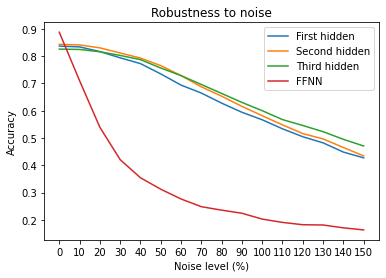

In [48]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
plot_noise_robustness_curves(noise_levels)

As we can see, when the epsilon is less than 0.1, our FFNN model works the best in comparison to linear read-outs but as we increase the level of noise the FFNN accuracy collapse and it will be highly sensitive when we increase the noise levels. (Accuracy is suddenly diminished by increasing the noise levels)

On the other hand, the situation is different with the linear read-out model. In comparison with the FFNN model, it will not be affected very much but as we already know the third hidden layer is more precise so as a result, it is more sustainable against the noise in comparison with the first and second hidden layers.

## Add some noises and adversarial attacks

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

Here we implement a simple FGSM attack.

In [49]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In this section we implement DBN read-out version.

In [89]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_FashionMNIST, readouts, readout_level=1):
        super().__init__()
        self.readouts = readouts
        self.dbn_FashionMNIST = dbn_FashionMNIST
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
        for rbm in self.dbn_FashionMNIST.rbm_layers:
            rbm.W.requires_grad_()
            rbm.h_bias.requires_grad_()

    def forward(self, image):
        """This forward pass uses probabilities instead of samples as RBM outputs
         to backpropagate the gradient"""
        p_v = image
        hidden_states = []
        for rbm in self.dbn_FashionMNIST.rbm_layers:
            p_v = p_v.view((p_v.shape[0], -1)).type(torch.FloatTensor).to(device)
            p_v, v = rbm(p_v)
            hidden_states.append(p_v)
        return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [90]:
dbn_with_readout = DBNWithReadOut(dbn_FashionMNIST, [linear1, linear2, linear3])

Here we see what an adversiarial sample looks like. Let't take one sample from the test set:

True label for the test sample is: tensor(3)


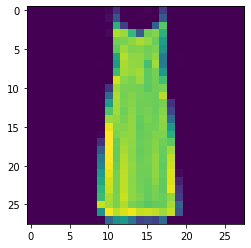

In [122]:
test_sample_idx = 13
test_image = FashionMNIST_test.data[test_sample_idx].reshape(1, 784)
print('True label for the test sample is: ' + str(FashionMNIST_test.targets[test_sample_idx]))
__ = plt.imshow(test_image.reshape(28, 28).to('cpu'))

Here we classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

To change the model we attack, you can modify the value of the model variable in the cell below.

In [123]:
attacked_model = ffnn

In [124]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image.to(device))
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 3.


In this section, we configure the attack and noising settings

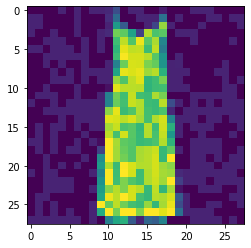

In [125]:
# We define strenght of the attack
epsilon = 0.1

# Getting the ground truth label for that image
test_image_label = FashionMNIST_test.targets[test_sample_idx].unsqueeze(0)

# Getting the loss value
loss_value = torch.nn.functional.cross_entropy(model_outputs.to(device), test_image_label.to(device))
attacked_model.zero_grad()
loss_value.backward()

# Getting the gradient of the pixels w.r.t. the loss
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

We check the prediction result here:

In [126]:
model_outputs = attacked_model(perturbed_image.to(device).view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 1.


We can observe that the algorithm is confused and make the prediction wrong. (Actual label is 3 but the prediction is 1). So we can see that the FFNN model is confused with the attack.

Here we do the exact thing for the DBN with read out to compare the result with the FFNN model.

In [127]:
attacked_model = dbn_with_readout

In [128]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image.to(device))
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 3.


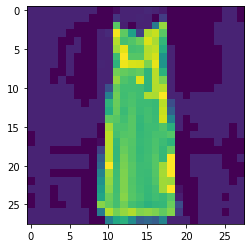

In [129]:
# We define strenght of the attack
epsilon = 0.1

# Getting the ground truth label for that image
test_image_label = FashionMNIST_test.targets[test_sample_idx].unsqueeze(0)

# Getting the loss value
loss_value = torch.nn.functional.cross_entropy(model_outputs.to(device), test_image_label.to(device))
attacked_model.zero_grad()
loss_value.backward()

# Getting the gradient of the pixels w.r.t. the loss
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [130]:
model_outputs = attacked_model(perturbed_image.to(device).view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 3.


As we can see despite the same noise (epsilon = 0.1) we inject, the DBN model with read out predict the label of noisy image truly.

## Resisting to adversarial attacks

Let's now compare the ability to resist adversarial attacks of our models: the feedforward network, DBN and, top down DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [57]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
            print("\nHere's the original sample:\n")
            plt.imshow(data[0].detach().to('cpu').numpy().reshape(28, 28))
            plt.show()

        loss = nn.functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        # Collect the gradient of the input data
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28, 28))
            plt.show()

        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_FashionMNIST.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28, 28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # Get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc * 100))

    return final_acc.item()

In [58]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False,
                             transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [59]:
final_acc1 = test_robustness_to_attack(ffnn, device, test_loader, epsilon=0.05, num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 85.14it/s]


Epsilon: 0.05
Test Accuracy: 3.08%



In [60]:
final_acc2 = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.05, num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 77.64it/s]


Epsilon: 0.05
Test Accuracy: 68.53%



  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



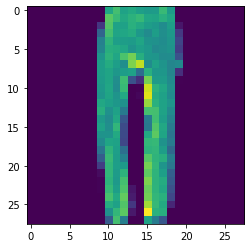


Here's a perturbed sample:



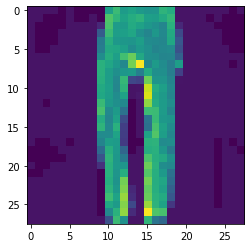


Here's what a 1-steps reconstructed sample looks like:



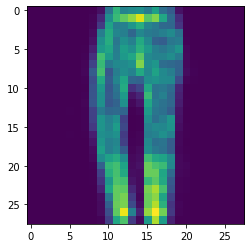

100%|██████████| 100/100 [00:01<00:00, 51.82it/s]


Epsilon: 0.05
Test Accuracy: 66.16%



In [61]:
final_acc2 = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.05, num_steps=1)

In [62]:
epsilon_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]


def test_epsilon_values_effect(model, n_steps):
    accuracies = list()

    for eps in epsilon_values:
        acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
        accuracies.append(acc)

    return accuracies

In [63]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

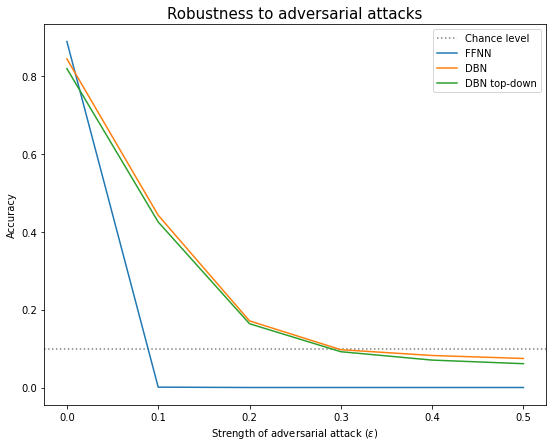

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

As a result, robustness to adversarial attacks in the DBN system is much better than the FFNN model and it can resist better against attacks even if we use an array of epsilons and increase the strength of attack.

## Final conclusion

The FFNN model as a supervised system could be better than the linear read-out DBN in terms of prediction of the clean images, but in terms of resistance to the noise and attack, the DBN approach has a much better result and can resist against attacks much better.